# Setup

## Imports and connecting to Google Drive

In [1]:
!python --version

Python 3.7.13


In [2]:
import os.path as op
import os
import xml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

import os
import numpy as np
import pickle
import torch
import torch.nn as nn

import glob

# connect to the shared Google Drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

os.chdir("/gdrive/Shareddrives/Dream Research w  NXT/dataset")
os.listdir()

files = glob.glob(f"/gdrive/Shareddrives/Dream Research w  NXT/dataset")

Mounted at /gdrive


## Data loading

In [3]:
from numpy.lib.stride_tricks import as_strided

def deinterleave(trial_data: np.ndarray, num_bands: int = 5) -> np.ndarray:
    """
    Takes a trial data array of shape (num_timesteps, num_electrodes*num_bands)
    and separates the electrodes/bands into separate dimensions, returning a view
    with shape (num_timesteps, num_electrodes, num_bands).
    """
    num_timesteps, num_channels = trial_data.shape
    timestep_stride, channel_stride = trial_data.strides

    assert num_channels % num_bands == 0
    num_electrodes = num_channels // num_bands

    return as_strided(
        trial_data,
        shape=(num_timesteps, num_electrodes, num_bands),
        strides=(timestep_stride, channel_stride*num_bands, channel_stride),
    )

In [4]:
from __future__ import annotations

import pickle
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

os.chdir("/gdrive/Shareddrives/Dream Research w  NXT/dataset")

seed5_folder = Path("/gdrive/Shareddrives/Dream Research w  NXT/dataset/SEED-V")
eeg_de_features_dir = seed5_folder / 'EEG_DE_features' / 'EEG_DE_features'

def load_subject_data(subject_num: int) -> tuple[list[np.ndarray], np.ndarray]:
    """
    Loads the EEG DE data for a subject (1-16). Returns a tuple of two items:

    trials_de:
        List of ndarrays, each with shape (num_timesteps, num_electrodes, num_bands).
        There are 45 elements in the list, one for each trial for this subject.
    trials_label:
        ndarray of integers with shape (45,).
        Each element is the label (0-4) for the corresponding trial.
    """
    with np.load(eeg_de_features_dir / f'{subject_num}_123.npz') as file_data: 
        trials_de = pickle.loads(file_data['data'].item())
        trials_label = pickle.loads(file_data['label'].item())

    num_trials = len(trials_label)
    assert num_trials == 45
    assert set(trials_label.keys()) == set(range(num_trials))
    assert set(trials_de.keys()) == set(range(num_trials))

    for labels in trials_label.values():
        assert all(label == labels[0] for label in labels)

    trials_de = [deinterleave(trials_de[i]) for i in range(num_trials)]
    trials_label = np.array([int(trials_label[i][0]) for i in range(num_trials)])

    return trials_de, trials_label

trials_de, trials_label = load_subject_data(16)
print('Trial labels:')
print(trials_label)

Trial labels:
[4 1 3 2 0 4 1 3 2 0 4 1 3 2 0 2 1 3 0 4 4 0 3 2 1 3 4 1 2 0 2 1 3 0 4 4 0
 3 2 1 3 4 1 2 0]


# Data visualization

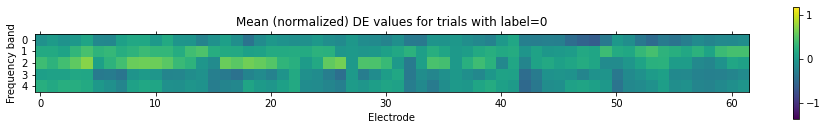

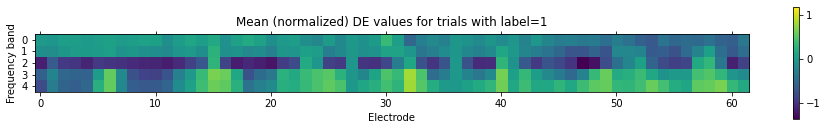

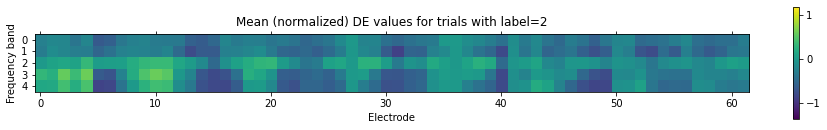

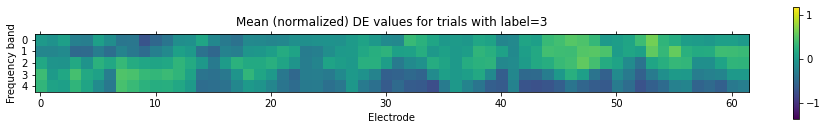

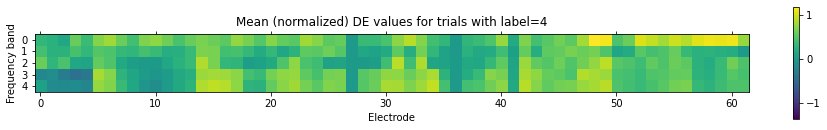

In [5]:
#@title
trials_de, trials_label = load_subject_data(16)
trials_de_means = np.array([de.mean(axis=0) for de in trials_de])

normalize = True

if normalize:
    # normalize to mean=0 std=1 over all trials
    trials_de_means -= trials_de_means.mean(axis=0, keepdims=True)
    trials_de_means /= trials_de_means.std(axis=0, keepdims=True)

mean_de_values_by_label = np.array([
    trials_de_means[trials_label == label].mean(axis=0)
    for label in range(5)
])
min_value = mean_de_values_by_label.min()
max_value = mean_de_values_by_label.max()
for label, mean_de_values in enumerate(mean_de_values_by_label):
    plt.matshow(mean_de_values.T, vmin=min_value, vmax=max_value)
    plt.colorbar()
    plt.title(f"Mean{' (normalized)' if normalize else ''} DE values for trials with label={label}", pad=5)
    plt.tick_params(labelbottom=True, labeltop=False)
    plt.xlabel("Electrode")
    plt.ylabel("Frequency band")
    plt.show()

trial.shape=(18, 62, 5)


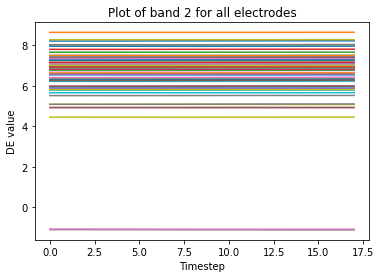

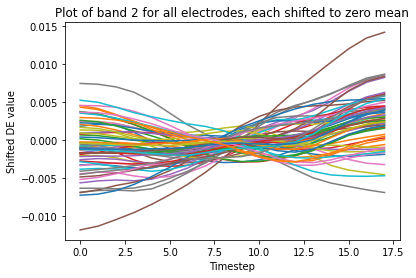

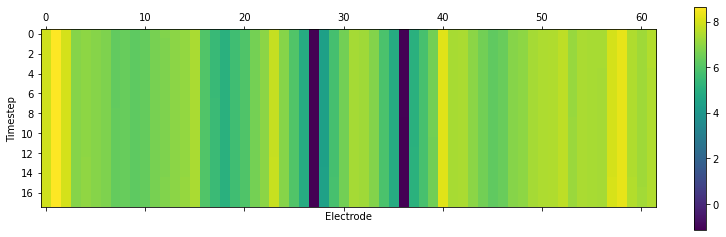

In [6]:
#@title
trials_de, trials_label = load_subject_data(16)
trial = trials_de[0]
print(f'trial.shape={trial.shape}')

band_index = 2

plt.title(f"Plot of band {band_index} for all electrodes")
plt.xlabel("Timestep")
plt.ylabel("DE value")
for electrode_index in range(trial.shape[1]):
    time_series = trial[:, electrode_index, band_index]
    plt.plot(time_series)
plt.show()

plt.title(f"Plot of band {band_index} for all electrodes, each shifted to zero mean")
plt.xlabel("Timestep")
plt.ylabel("Shifted DE value")
for electrode_index in range(trial.shape[1]):
    time_series = trial[:, electrode_index, band_index]
    plt.plot(time_series - time_series.mean())
plt.show()

plt.matshow(trial[:,:,band_index])
plt.xlabel("Electrode")
plt.ylabel("Timestep")
plt.colorbar()
plt.show()

# SVM classification

In [7]:
# prepare data for SVM classifier
import random

trials_de = []
trials_label = []
subject_nums = list(range(1, 16+1))
random.shuffle(subject_nums)
for subject_num in subject_nums:
    subject_trials_de, subject_trials_label = load_subject_data(subject_num)
    random.shuffle(subject_trials_de)
    trials_de.extend(subject_trials_de)
    trials_label.append(subject_trials_label)
trials_label = np.concatenate(trials_label)
print(f'trials_label.shape={trials_label.shape}')
print(f'len(trials_de)={len(trials_de)}')

trial = trials_de[0]
print(f'trial.shape={trial.shape}')

[trial.shape[0] for trial in trials_de]

timesteps_features = []
timesteps_labels = []
for trial_de, trial_label in zip(trials_de, trials_label):
    # trial_de = trial_de.copy()
    # trial_de -= trial_de.mean()
    # trial_de /= trial_de.std()
    for timestep_de in trial_de:
        timesteps_features.append(timestep_de.ravel())
        timesteps_labels.append(trial_label)

    # timesteps_features.append(trial_de.mean(axis=0).ravel())
    # timesteps_features.append(trial_de[0].ravel())
    # timesteps_labels.append(trial_label)

timesteps_features = np.array(timesteps_features)
timesteps_labels = np.array(timesteps_labels)

# feature_indices = random.sample(range(timesteps_features.shape[1]), k=10)
# timesteps_features = timesteps_features[:, feature_indices]

print(f'timesteps_features.shape={timesteps_features.shape}')
print(f'timesteps_labels.shape={timesteps_labels.shape}')

from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    timesteps_features,
    timesteps_labels,
    test_size=0.25,
    shuffle=False,
    random_state=42,
)
print(f'train_X.shape={train_X.shape}')
print(f'test_X.shape={test_X.shape}')

trials_label.shape=(720,)
len(trials_de)=720
trial.shape=(60, 62, 5)
timesteps_features.shape=(29168, 310)
timesteps_labels.shape=(29168,)
train_X.shape=(21876, 310)
test_X.shape=(7292, 310)


In [8]:
from sklearn import svm

clf = svm.SVC()
clf.fit(train_X, train_y)

accuracy = clf.score(train_X, train_y)
print("Train accuracy:", accuracy)

accuracy = clf.score(test_X, test_y)
print("Test accuracy:", accuracy)

Train accuracy: 0.5844304260376668
Test accuracy: 0.14056500274273176


# Linear SVM

In [9]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = make_pipeline(
    PCA(n_components=100),
    StandardScaler(),
    LinearSVC(
        random_state=42,
        max_iter=1_000,
        C=0.1,
    ),
)
clf.fit(train_X, train_y)

accuracy = clf.score(train_X, train_y)
print("Train accuracy:", accuracy)

accuracy = clf.score(test_X, test_y)
print("Test accuracy:", accuracy)

Train accuracy: 0.5651398793198025
Test accuracy: 0.2371091607240812


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


```
Train accuracy: 0.5414152495885902
Test accuracy: 0.23381788261108064
```

# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

clf = make_pipeline(
    # StandardScaler(),
    PCA(n_components=100),
    RandomForestClassifier(
        max_depth=7,
        random_state=42,
    ),
)
clf.fit(train_X, train_y)

accuracy = clf.score(train_X, train_y)
print("Train accuracy:", accuracy)

accuracy = clf.score(test_X, test_y)
print("Test accuracy:", accuracy)

Train accuracy: 0.9950173706344853
Test accuracy: 0.1703236423477784


```
Train accuracy: 0.6901627354178095
Test accuracy: 0.21448162369720242
```

# XGBoost

In [ ]:
# idk implement this whenever

 # Dummy Classifier (baseline)

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(train_X, train_y)

accuracy = dummy_clf.score(train_X, train_y)
print("Dummy train accuracy:", accuracy)

accuracy = dummy_clf.score(test_X, test_y)
print("Dummy test accuracy:", accuracy)

Dummy train accuracy: 0.2052020479063814
Dummy test accuracy: 0.204059243006034


# Exploration/testing

In [12]:
#@title
def loading_cv_data(eeg_dir, eye_dir, file_name, cv_number):
    eeg_data_pickle = np.load( os.path.join(eeg_dir, file_name))
    eye_data_pickle = np.load( os.path.join(eye_dir, file_name))
    

    
    eeg_data = pickle.loads(eeg_data_pickle['data'])
    eye_data = pickle.loads(eye_data_pickle['data'])
    label = pickle.loads(eeg_data_pickle['label'])
    list_1 = [0,1,2,3,4,15,16,17,18,19,30,31,32,33,34]
    list_2 = [5,6,7,8,9,20,21,22,23,24,35,36,37,38,39]
    list_3 = [10,11,12,13,14,25,26,27,28,29,40,41,42,43,44]
    if cv_number == 1:
        print('#1 as test, preparing data')
        train_list = list_2 + list_3
        test_list = list_1
    elif cv_number == 2:
        print('#2 as test, preparing data')
        train_list = list_1 + list_3
        test_list = list_2
    else:
        print('#3 as test, preparing data')
        train_list = list_1 + list_2
        test_list = list_3

    train_eeg = []
    test_eeg = []
    train_label = []
    for train_id in range(len(train_list)):
        train_eeg_tmp = eeg_data[train_list[train_id]]
        train_eye_tmp = eye_data[train_list[train_id]]
        train_label_tmp = label[train_list[train_id]]
        if train_id == 0:
            train_eeg = train_eeg_tmp
            train_eye = train_eye_tmp
            train_label = train_label_tmp
        else:
            train_eeg = np.vstack((train_eeg, train_eeg_tmp))
            train_eye = np.vstack((train_eye, train_eye_tmp))
            train_label = np.hstack((train_label, train_label_tmp))
    assert train_eeg.shape[0] == train_eye.shape[0]
    assert train_eeg.shape[0] == train_label.shape[0]

    test_eeg = []
    test_eye = []
    test_label = []
    for test_id in range(len(test_list)):
        test_eeg_tmp = eeg_data[test_list[test_id]]
        test_eye_tmp = eye_data[test_list[test_id]]
        test_label_tmp = label[test_list[test_id]]
        if test_id == 0:
            test_eeg = test_eeg_tmp
            test_eye = test_eye_tmp
            test_label = test_label_tmp
        else:
            test_eeg = np.vstack((test_eeg, test_eeg_tmp))
            test_eye = np.vstack((test_eye, test_eye_tmp))
            test_label = np.hstack((test_label, test_label_tmp))
    assert test_eeg.shape[0] == test_eye.shape[0]
    assert test_eeg.shape[0] == test_label.shape[0]

    train_all = np.hstack((train_eeg, train_eye, train_label.reshape([-1,1])))
    test_all = np.hstack((test_eeg, test_eye, test_label.reshape([-1,1])))
    return train_all, test_all



In [13]:

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir("/gdrive/Shareddrives/Dream Research w  NXT/dataset")
os.listdir()
seed5_folder = 'SEED-V'
## DE features
eeg_de_features = os.path.join(seed5_folder, 'EEG_DE_features/EEG_DE_features')
data = np.zeros((0,0))
files = os.listdir(eeg_de_features)

# (eeg_de_features)["idx of subjects"]
with np.load(os.path.join(eeg_de_features, os.listdir(eeg_de_features)[0])) as file1: 
  data1 = file1['data'].item()
  label1 = file1['label'].item()
  

print("===================")
print("Data 1:")
seed5Datasets = pickle.loads(data1)
print(len(seed5Datasets.values()))
for val in seed5Datasets.values():
  print(val)
  print(val.shape)
print("===================")


seed5Datasets = pickle.loads(label1)
# print("Label1")
# print(len(seed5Datasets))
# print(seed5Datasets)
# print(type(seed5Datasets))


# for val in seed5Datasets.values():
#   print(val)
#   print(val.shape)


# data1
# print(len(data1))
seed5Datasets = pickle.loads(data1)
# or maybe
# pickle.loads(data1.item())



# print( type(seed5Datasets))
# print("================")
# print( len( seed5Datasets[0].shape))
# print("================")
# print(seed5Datasets[0].shape)
# print("================")
# print(len(seed5Datasets))

Data 1:
45
[[9.89500949 8.57633621 7.16057652 ... 7.86459439 5.53520007 3.39389349]
 [9.89528643 8.5768024  7.16093354 ... 7.86474953 5.53528205 3.39373965]
 [9.89588925 8.57767535 7.161292   ... 7.86488374 5.53546413 3.39342837]
 ...
 [9.90346161 8.5880895  7.15944655 ... 7.86769061 5.54192868 3.37981788]
 [9.9026273  8.58821876 7.15909213 ... 7.86867979 5.5426509  3.37862291]
 [9.90176828 8.58771376 7.1583478  ... 7.86925142 5.54309004 3.37803619]]
(18, 310)
[[10.14397821  8.46675501  6.9862091  ...  7.98003324  5.51145955
   3.34359855]
 [10.14354405  8.46701695  6.98588837 ...  7.98026157  5.5113363
   3.34323194]
 [10.14304164  8.46742468  6.98516018 ...  7.98052556  5.51115889
   3.34264296]
 ...
 [10.16362577  8.47548452  6.95683079 ...  7.968166    5.50347517
   3.34264888]
 [10.16337774  8.47469888  6.95598059 ...  7.96721443  5.50372167
   3.34384645]
 [10.16315688  8.47406814  6.9552031  ...  7.9666976   5.50398067
   3.34478119]]
(24, 310)
[[10.14738748  8.56025791  7.24632

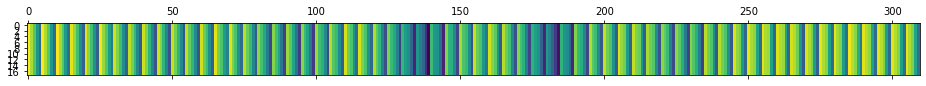

In [14]:
#@title
# ax = plt.imshow(seed5Datasets[0])
ax = plt.matshow(seed5Datasets[0])

plt.show()